## DNN Model Eğitimi

Bu notebook, DNN modelini eğitir ve değerlendirir. En iyi veri seti filtrelenmiş veri setidir. Bu nedenle sadece onunla deneyler gerçekleştirilmiştir. 
| Metrik | Accuracy | Precision | Recall | F1 Score |
|--------|----------|-----------|---------|-----------|
| Validation | 0.9842 | 0.9776 | 0.9800 | 0.9788 |
| Test | 0.9791 | 0.9677 | 0.9766 | 0.9722 |

In [5]:
import pandas as pd
import os

data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data")
filtered_train_data = pd.read_csv(os.path.join(data_dir, "filtered_train_val_excluded.csv"))
filtered_val_data = pd.read_csv(os.path.join(data_dir, "filtered_validation.csv"))
filtered_test_data = pd.read_csv(os.path.join(data_dir, "filtered_test.csv"))
print(f"filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape: {filtered_test_data.shape}")
print(f"filtered val data shape: {filtered_val_data.shape}")


filtered train data shape: (12200, 5)
filtered test data shape: (2630, 4)
filtered val data shape: (2153, 5)


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
import mlflow.keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import os
def train_and_evaluate_dnn(train_data, val_data, test_data, dataset_name,
                          experiment_name, out_dir, text_column='email_text'):
    """
    DNN modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    with mlflow.start_run(run_name=f"DNN_{dataset_name}"):
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        X_train = vectorizer.fit_transform(train_data[text_column]).toarray()
        X_val = vectorizer.transform(val_data[text_column]).toarray()
        X_test = vectorizer.transform(test_data[text_column]).toarray()
        
        model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])
        
        model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        
        # Model eğitimi
        history = model.fit(
            X_train, train_data['label'],
            epochs=100,
            batch_size=32,
            validation_data=(X_val, val_data['label']),
            callbacks=[early_stopping]
        )
        
        val_pred = (model.predict(X_val) > 0.5).astype(int)
        test_pred = (model.predict(X_test) > 0.5).astype(int)
        
        val_metrics = {
            'val_accuracy': accuracy_score(val_data['label'], val_pred),
            'val_precision': precision_score(val_data['label'], val_pred),
            'val_recall': recall_score(val_data['label'], val_pred),
            'val_f1': f1_score(val_data['label'], val_pred)
        }
        
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['label'], test_pred),
            'test_precision': precision_score(test_data['label'], test_pred),
            'test_recall': recall_score(test_data['label'], test_pred),
            'test_f1': f1_score(test_data['label'], test_pred)
        }
        
        # MLflow'a parametreleri ve metrikleri kaydet
        mlflow.log_params({
            "dataset": dataset_name,
            "architecture": "DNN",
            "max_features": 5000,
            "ngram_range": "(1,2)"
        })
        mlflow.log_metrics({**val_metrics, **test_metrics})
        
        # Modeli kaydet
        os.makedirs(out_dir, exist_ok=True)
        model_path = os.path.join(out_dir, f"{dataset_name}_dnn.h5")
        vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
        
        model.save(model_path)
        joblib.dump(vectorizer, vectorizer_path)
        
        # MLflow'a modeli kaydet
        mlflow.keras.log_model(model, "model")
        
        # Confusion matrix'leri görselleştir ve kaydet
        plot_and_log_confusion_matrix(
            val_data['label'],
            val_pred,
            'Validation Seti Confusion Matrix',
            os.path.join(out_dir, "validation_confusion_matrix.png")
        )
        
        plot_and_log_confusion_matrix(
            test_data['label'],
            test_pred,
            'Test Seti Confusion Matrix',
            os.path.join(out_dir, "test_confusion_matrix.png")
        )
        
        # Sonuçları yazdır
        print(f"\nValidation metrikleri:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
        
    return model, vectorizer, val_pred, test_pred


Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8345 - loss: 0.3626 - val_accuracy: 0.9029 - val_loss: 0.2463
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9727 - loss: 0.0759 - val_accuracy: 0.9758 - val_loss: 0.0647
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9814 - loss: 0.0535 - val_accuracy: 0.9814 - val_loss: 0.0645
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9874 - loss: 0.0372 - val_accuracy: 0.9842 - val_loss: 0.0604
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0346 - val_accuracy: 0.9814 - val_loss: 0.0671
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9907 - loss: 0.0263 - val_accuracy: 0.9810 - val_loss: 0.0734
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9907 - loss: 0.0262 - val_accuracy: 0.9810 - val_loss: 0.0812
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


2024/12/31 04:10:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/31 04:10:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


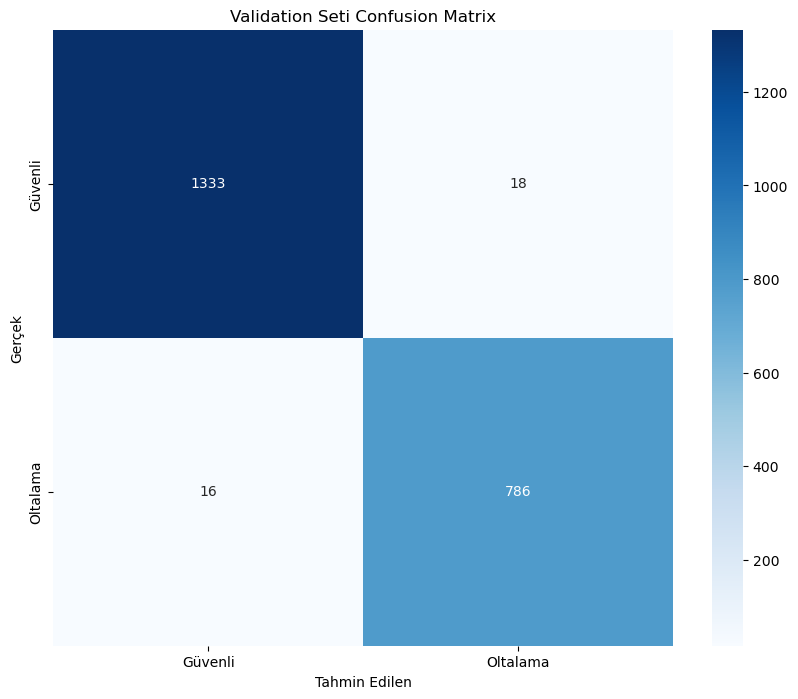


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1333
False Positives (Güvenli yanlış tahmin): 18
False Negatives (Oltalama yanlış tahmin): 16
True Positives (Oltalama doğru tahmin): 786


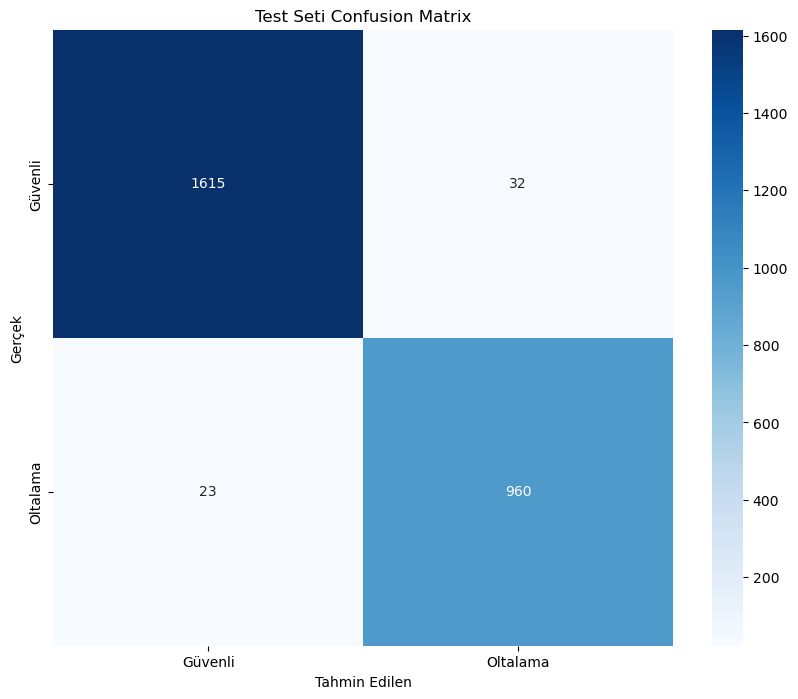


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1615
False Positives (Güvenli yanlış tahmin): 32
False Negatives (Oltalama yanlış tahmin): 23
True Positives (Oltalama doğru tahmin): 960

Validation metrikleri:
val_accuracy: 0.9842
val_precision: 0.9776
val_recall: 0.9800
val_f1: 0.9788

Test metrikleri:
test_accuracy: 0.9791
test_precision: 0.9677
test_recall: 0.9766
test_f1: 0.9722


In [13]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "dnn")
model, vectorizer, val_pred, test_pred =train_and_evaluate_dnn(filtered_train_data, filtered_val_data, filtered_test_data, "filtered", "dnn_experiments", model_dir)